{'buildings' -> 0, 

'forest' -> 1,

'glacier' -> 2,

'mountain' -> 3,

'sea' -> 4,

'street' -> 5 }

In [0]:
labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
home_dir = '/content/gdrive/My Drive/data-science-my-projects/AV-Intel-Scene-Classification-Challenge'
print(os.listdir(home_dir))

['scene-classification-cnn-data-aug-vgg16.ipynb', 'dataset', 'submissions', 'scene-classification-cnn-data-aug-resnet50.ipynb']


## Read and set up data

In [0]:
# Read data
dataset_dir = os.path.join(home_dir, "dataset")
train_dir = os.path.join(dataset_dir, "train")


train_df = pd.read_csv(dataset_dir + '/train.csv')
train_df.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


Image shape = (150, 150, 3)


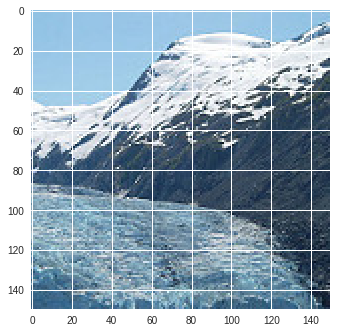

In [0]:
# Read and display an image
image = plt.imread(os.path.join(train_dir, os.listdir(train_dir)[25]))
print("Image shape =", image.shape)
train_input_shape = image.shape
plt.imshow(image)
plt.show()

In [0]:
# Number of unique classes
n_classes = len(train_df.label.unique())
print("Number of unique classes =", n_classes)

Number of unique classes = 6


## Image Augmentation

In [0]:
# Augment data
batch_size = 16
train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   #vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df, 
                                                    directory=train_dir, 
                                                    x_col="image_name", 
                                                    y_col="label", 
                                                    class_mode="other",
                                                    subset="training",
                                                    target_size=train_input_shape[0:2], 
                                                    batch_size=batch_size)

valid_generator = train_datagen.flow_from_dataframe(dataframe=train_df, 
                                                    directory=train_dir, 
                                                    x_col="image_name", 
                                                    y_col="label", 
                                                    class_mode="other",
                                                    subset="validation",
                                                    target_size=train_input_shape[0:2], 
                                                    batch_size=batch_size)

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 13628 images.
Found 3406 images.
Total number of batches = 851 and 212


## Build model

In [0]:
# Load pre-trained model
vgg16_net = VGG16(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in vgg16_net.layers:
    layer.trainable = False

vgg16_net.summary()

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_____

In [0]:
# Add layers at the end
X = vgg16_net.output
X = Flatten()(X)

X = Dropout(0.5)(X)
X = Dense(512, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dropout(0.5)(X)
X = Dense(16, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)

model = Model(inputs=vgg16_net.input, outputs=output)

model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
___________________________

In [0]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(lr=0.0001), 
              metrics=['accuracy'])

In [0]:
early_stop = EarlyStopping(monitor='val_acc', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, 
                              verbose=1, mode='auto')

In [0]:
%%time
n_epoch = 5

history = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[early_stop, reduce_lr],
                              use_multiprocessing=True,
                              workers=10
                             )

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
852/852 [==============================] - 600s 705ms/step - loss: 1.2400 - acc: 0.5594 - val_loss: 0.8525 - val_acc: 0.7689
Epoch 2/5
852/852 [==============================] - 190s 223ms/step - loss: 0.9188 - acc: 0.7070 - val_loss: 0.7008 - val_acc: 0.7951
Epoch 3/5
213/213 [==============================] - 37s 173ms/step - loss: 0.6008 - acc: 0.8186
 - 37s 173ms/step - loss: 0.6008 - acc: 0.8186
852/852 [==============================] - 189s 222ms/step - loss: 0.7964 - acc: 0.7411 - val_loss: 0.6008 - val_acc: 0.8186
Epoch 4/5
852/852 [==============================] - 188s 221ms/step - loss: 0.7340 - acc: 0.7489 - val_loss: 0.5625 - val_acc: 0.8200
Epoch 5/5
852/852 [==============================] - 189s 222ms/step - loss: 0.6935 - acc: 0.7567 - val_loss: 0.5265 - val_acc: 0.8180
CPU times: user 3min 28s, sys: 45.5 s, total: 4min 14s
Wall time: 22min 38s


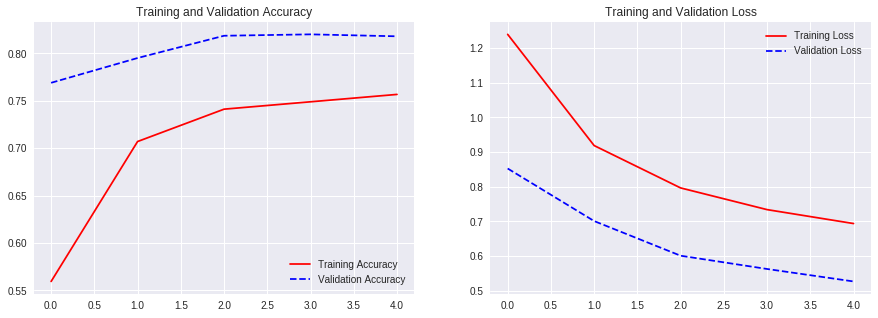

In [0]:
# Plot the training graph
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()
    
plot_training(history)

In [0]:
# Evaluate on validation set
result = model.evaluate_generator(generator=valid_generator, verbose=1)
result

213/213 [==============================] - 44s 204ms/step - loss: 0.5081 - acc: 0.8262


[0.5081202256287767, 0.8261891]

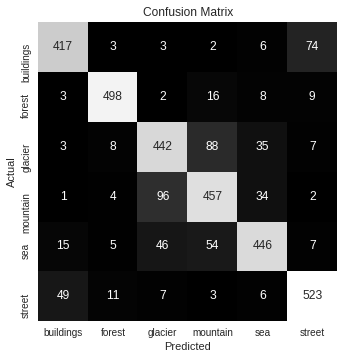

              precision    recall  f1-score   support

           0       0.85      0.83      0.84       505
           1       0.94      0.93      0.94       536
           2       0.74      0.76      0.75       583
           3       0.74      0.77      0.75       594
           4       0.83      0.78      0.81       573
           5       0.84      0.87      0.86       599

   micro avg       0.82      0.82      0.82      3390
   macro avg       0.82      0.82      0.82      3390
weighted avg       0.82      0.82      0.82      3390



ValueError: ignored

In [0]:
# Classification report and confusion matrix
from sklearn.metrics import *
import seaborn as sns

def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    
    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    #y_pred = np.asarray(y_pred).astype('float32').ravel()
    #y_pred = y_pred >= 0.5
    #y_pred = y_pred.astype('int').ravel()
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4,5])
    sns.heatmap(conf_matrix, annot=True, fmt="d", square=True, cbar=False, 
                cmap=plt.cm.gray, xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()
    
    print(classification_report(y_true, y_pred))
    #print("\nAUC: ", roc_auc_score(y_true, y_pred, average='micro'))

showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID)

## Prepare data for prediction on test set

In [0]:
test_df = pd.read_csv(dataset_dir + "/test_WyRytb0.csv")
test_df.shape

(7301, 1)

In [0]:
test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(dataframe=test_df, 
                                                    directory=train_dir, 
                                                    x_col="image_name", 
                                                    #y_col="label", 
                                                    class_mode=None,
                                                    target_size=train_input_shape[0:2], 
                                                    batch_size=1,
                                                    shuffle=False
                                                 )

Found 7301 images.


## Predict and Submit

In [0]:
# Predict on test data
test_generator.reset()
predictions = model.predict_generator(test_generator,verbose=1)
predictions = np.argmax(predictions, axis=1)
#predictions = predictions.astype('int').ravel()
predictions.shape

7301/7301 [==============================] - 1926s 264ms/step


array([[5.05507924e-02, 5.84810274e-03, 1.24183425e-03, 5.16098400e-04,
        1.26998592e-02, 9.29143310e-01],
       [9.45217609e-01, 9.87100182e-04, 6.35538111e-03, 6.46574656e-03,
        1.27264261e-02, 2.82477736e-02],
       [2.77818609e-02, 1.35548785e-02, 4.48729768e-02, 8.56120586e-02,
        8.05312693e-01, 2.28655487e-02],
       ...,
       [1.88080914e-04, 4.01056968e-05, 9.84495342e-01, 1.35393143e-02,
        1.58637378e-03, 1.50749969e-04],
       [1.05392672e-02, 9.40815151e-01, 1.43868672e-02, 7.71071436e-03,
        2.01854855e-02, 6.36256533e-03],
       [8.50100219e-01, 5.72717376e-03, 2.19693929e-02, 1.79790799e-02,
        3.22046131e-02, 7.20194429e-02]], dtype=float32)

In [0]:
# Retrieve filenames
import re
#test_img_ids = [re.split("/", val)[1] for val in test_generator.filenames]
test_img_ids = test_generator.filenames
len(test_img_ids)

7301

In [0]:
# Create dataframe for submission
submission_df = pd.DataFrame({'image_name' : test_img_ids,
                              'label' : predictions })
submission_df.head()

,image_name,label
0,3.jpg,5
1,5.jpg,0
2,6.jpg,4
3,11.jpg,2
4,14.jpg,5


In [0]:
# Create submission file
submission_dir = os.path.join(home_dir, "submissions")
submission_df.to_csv(submission_dir + '/submission_vgg16_1.csv', index=False)